In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Load the uploaded data
file_path = "../../artifacts/data/processed/regime_input.csv"
df = pd.read_csv(file_path)

# Identify regime-related boolean columns (those ending in _Bull or _Bear)
regime_columns = [col for col in df.columns if any(col.endswith(suffix) for suffix in ["_Bull", "_Bear"])]

# Calculate frequency and percentage for each regime column
regime_summary = pd.DataFrame(columns=["Signal", "True_Count", "Percent_True"])

total_rows = len(df)
for col in regime_columns:
    # Ensure the column is treated as boolean (True/False) or numeric (0/1)
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)  # Convert to 0/1 if necessary
    
    # Now calculate the true count
    true_count = df[col].sum()
    percent_true = (true_count / total_rows) * 100
    regime_summary = pd.concat([regime_summary, pd.DataFrame([{
        "Signal": col,
        "True_Count": int(true_count),
        "Percent_True": round(percent_true, 2)
    }])], ignore_index=True)

# Display the summary
print(regime_summary)


                     Signal True_Count  Percent_True
0                Trend_Bull        325         17.39
1                Trend_Bear        323         17.28
2            Expansion_Bull        588         31.46
3            Expansion_Bear        620         33.17
4  Momentum_Divergence_Bull         77          4.12
5  Momentum_Divergence_Bear         80          4.28
6   Classic_Divergence_Bull        150          8.03
7   Classic_Divergence_Bear        142          7.60
8                  RHD_Bull          0          0.00
9                  RHD_Bear          0          0.00


/var/folders/4q/cv174s2d24n6j71rjjzfsk6w0000gn/T/ipykernel_8136/1442382780.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regime_summary = pd.concat([regime_summary, pd.DataFrame([{


In [3]:
regime_summary

,Signal,True_Count,Percent_True
0,Trend_Bull,325,17.39
1,Trend_Bear,323,17.28
2,Expansion_Bull,588,31.46
3,Expansion_Bear,620,33.17
4,Momentum_Divergence_Bull,77,4.12
5,Momentum_Divergence_Bear,80,4.28
6,Classic_Divergence_Bull,150,8.03
7,Classic_Divergence_Bear,142,7.60
8,RHD_Bull,0,0.00
9,RHD_Bear,0,0.00


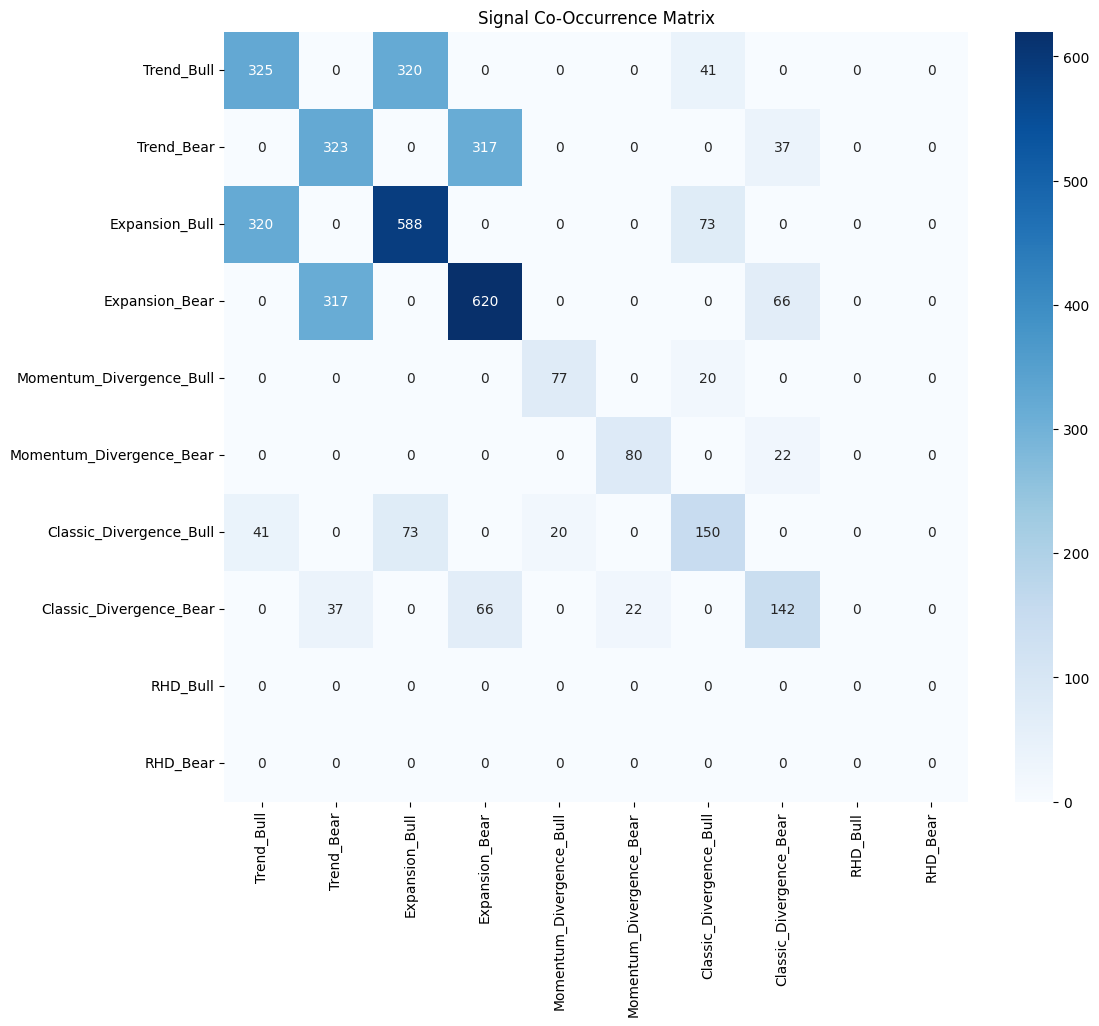

In [4]:
# Define all the binary signal columns
signal_cols = [
    "Trend_Bull", "Trend_Bear",
    "Expansion_Bull", "Expansion_Bear",
    "Momentum_Divergence_Bull", "Momentum_Divergence_Bear",
    "Classic_Divergence_Bull", "Classic_Divergence_Bear",
    "RHD_Bull", "RHD_Bear",
]

# Ensure they are boolean
df[signal_cols] = df[signal_cols].astype(bool)

# Compute co-occurrence counts
co_occurrence = pd.DataFrame(index=signal_cols, columns=signal_cols)

for col1 in signal_cols:
    for col2 in signal_cols:
        co_occurrence.loc[col1, col2] = ((df[col1]) & (df[col2])).sum()

co_occurrence = co_occurrence.astype(int)

# Optional: Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, annot=True, fmt="d", cmap="Blues")
plt.title("Signal Co-Occurrence Matrix")
plt.show()

In [5]:
# Convert boolean columns if needed (ensure True/False are 1/0)
binary_cols = [col for col in df.columns if col.endswith("_Bull") or col.endswith("_Bear")]
df[binary_cols] = df[binary_cols].astype(bool)

# --- Check 1: Conflicting signal flags (e.g., both Bull and Bear on same row) ---
conflicts = {}

# Grouped conflict checks
signal_groups = [
    ("Trend_Bull", "Trend_Bear"),
    ("Expansion_Bull", "Expansion_Bear"),
    ("Momentum_Divergence_Bull", "Momentum_Divergence_Bear"),
    ("Classic_Divergence_Bull", "Classic_Divergence_Bear"),
    ("RHD_Bull", "RHD_Bear"),
]

for bull_col, bear_col in signal_groups:
    conflict_rows = df[df[bull_col] & df[bear_col]]
    conflicts[f"{bull_col} & {bear_col}"] = len(conflict_rows)

# --- Check 2: Alignment with ML outputs ---
alignment = {
    "Buy_with_Bull_Signal": df[(df["ML_Trade_Direction"] == "Buy") & (df["Trend_Bull"])].shape[0],
    "Sell_with_Bear_Signal": df[(df["ML_Trade_Direction"] == "Sell") & (df["Trend_Bear"])].shape[0],
    "Flat_with_No_Trend": df[
        (df["ML_Trade_Direction"] == "Flat") &
        (~df["Trend_Bull"]) & (~df["Trend_Bear"])
    ].shape[0],
}



In [6]:
conflicts

{'Trend_Bull & Trend_Bear': 0,
 'Expansion_Bull & Expansion_Bear': 0,
 'Momentum_Divergence_Bull & Momentum_Divergence_Bear': 0,
 'Classic_Divergence_Bull & Classic_Divergence_Bear': 0,
 'RHD_Bull & RHD_Bear': 0}

In [7]:
# List of pairs of opposing signals
opposing_signal_pairs = [
    ('Trend_Bull', 'Trend_Bear'),
    ('Expansion_Bull', 'Expansion_Bear'),
    ('Momentum_Divergence_Bull', 'Momentum_Divergence_Bear'),
    ('Classic_Divergence_Bull', 'Classic_Divergence_Bear'),
    ('RHD_Bull', 'RHD_Bear'),
]

# Dictionary to store conflict counts
signal_conflicts = {}

# Loop through the pairs and check for conflicts
for signal_1, signal_2 in opposing_signal_pairs:
    conflict_count = ((df[signal_1] == True) & (df[signal_2] == True)).sum()
    signal_conflicts[f'{signal_1} & {signal_2}'] = conflict_count

# Print the result
for signal_pair, conflict_count in signal_conflicts.items():
    print(f'{signal_pair}: {conflict_count} conflicts')

Trend_Bull & Trend_Bear: 0 conflicts
Expansion_Bull & Expansion_Bear: 0 conflicts
Momentum_Divergence_Bull & Momentum_Divergence_Bear: 0 conflicts
Classic_Divergence_Bull & Classic_Divergence_Bear: 0 conflicts
RHD_Bull & RHD_Bear: 0 conflicts


In [8]:
alignment

{'Buy_with_Bull_Signal': 132,
 'Sell_with_Bear_Signal': 147,
 'Flat_with_No_Trend': 482}

Here is a description for each of the alignment conditions:

### 1. **Buy with Bull Signal**

* **Condition:** This counts how many instances in the dataset have an ML prediction of **Buy** and are also accompanied by a **Bullish Trend** signal.
* **Interpretation:** This represents the cases where both the model's prediction and the trend analysis align, signaling a clear Buy opportunity when a Bullish trend is detected.

### 2. **Sell with Bear Signal**

* **Condition:** This counts how many instances in the dataset have an ML prediction of **Sell** and are accompanied by a **Bearish Trend** signal.
* **Interpretation:** This represents the cases where both the model's prediction and the trend analysis align, signaling a Sell opportunity when a Bearish trend is detected.

### 3. **Flat with No Trend**

* **Condition:** This counts how many instances in the dataset have an ML prediction of **Flat** (indicating no action) and no detected **Trend** (i.e., no Bullish or Bearish trend).
* **Interpretation:** This represents the cases where the model predicts no action (Flat), and the trend signal shows no significant trend. It’s useful for ensuring that the model doesn't wrongly call a "Flat" when there is a trend in the market.

### 4. **Buy with Bearish Signal**

* **Condition:** This counts how many instances in the dataset have an ML prediction of **Buy** and are accompanied by a **Bearish Trend** signal.
* **Interpretation:** This represents conflicting signals where the model predicts a Buy (which implies a bullish market expectation) while the trend indicates a Bearish condition. These might be useful to evaluate for potential misalignments or model confusion.

### 5. **Sell with Bullish Signal**

* **Condition:** This counts how many instances in the dataset have an ML prediction of **Sell** and are accompanied by a **Bullish Trend** signal.
* **Interpretation:** Similar to the above, this is a conflict between the model’s Sell signal and a Bullish trend signal. The model predicts a Sell (which implies a bearish market expectation), while the trend shows a Bullish signal.

### 6. **Flat with Bullish Trend**

* **Condition:** This counts how many instances in the dataset have an ML prediction of **Flat** (no action) while there is a detected **Bullish Trend**.
* **Interpretation:** This shows cases where the model predicts "no action" (Flat) despite a Bullish trend being present. It could be useful for investigating whether the model is missing or downplaying strong trends.

### 7. **Flat with Bearish Trend**

* **Condition:** This counts how many instances in the dataset have an ML prediction of **Flat** (no action) while there is a detected **Bearish Trend**.
* **Interpretation:** This shows cases where the model predicts "no action" (Flat) despite a Bearish trend being present. Like the "Flat with Bullish Trend," this can be valuable for investigating potential under-reaction by the model to strong market signals.

### 8. **Buy with No Trend**

* **Condition:** This counts how many instances in the dataset have an ML prediction of **Buy** but no detected **Trend**.
* **Interpretation:** This represents cases where the model predicts a Buy signal without any supporting trend information. This could indicate situations where the model is acting on its own (perhaps a technical signal or event) rather than relying on trends.

### 9. **Sell with No Trend**

* **Condition:** This counts how many instances in the dataset have an ML prediction of **Sell** but no detected **Trend**.
* **Interpretation:** This represents cases where the model predicts a Sell signal without any supporting trend information. It might indicate a Sell action based purely on technical signals or market conditions that are not aligned with a clear trend.

---

Each of these conditions helps us understand how often the model’s predictions align or conflict with the trend signals. It’s essential for fine-tuning the model and understanding where it is performing well or needs improvement, especially in ambiguous market conditions.


In [9]:
# Define your ML predictions and signals
ml_column = 'ML_Trade_Direction'  # Example: ML predictions (Buy/Sell/Flat)

# Define the signal columns to align with ML predictions
bull_signal = 'Trend_Bull'  # Example: Bullish signal
bear_signal = 'Trend_Bear'  # Example: Bearish signal
no_trend_signal = 'Trend'  # Example: No trend signal (Flat)

# Create a dictionary to store alignment counts
signal_alignment = {
    'Buy_with_Bull_Signal': 0,
    'Sell_with_Bear_Signal': 0,
    'Flat_with_No_Trend': 0
}

# Check alignment
signal_alignment['Buy_with_Bull_Signal'] = ((df[ml_column] == 'Buy') & (df[bull_signal] == True)).sum()
signal_alignment['Sell_with_Bear_Signal'] = ((df[ml_column] == 'Sell') & (df[bear_signal] == True)).sum()
signal_alignment['Flat_with_No_Trend'] = ((df[ml_column] == 'Flat') & (df[no_trend_signal] == False)).sum()

# Print the alignment results
for alignment, count in signal_alignment.items():
    print(f'{alignment}: {count}')

Buy_with_Bull_Signal: 132
Sell_with_Bear_Signal: 147
Flat_with_No_Trend: 0


In [10]:
# Identify columns that contain NaN values
# file_path = "../../artifacts/data/processed/train.csv"
# df = pd.read_csv(file_path)
nan_columns = df.columns[df.isna().any()].tolist()

nan_columns

[]

In [11]:
# Count the number of NaN values per column
na_counts = df.isna().sum()

# Filter columns that have at least one NaN value
columns_with_na = na_counts[na_counts > 0]

# Print the result
print("Columns with NaN values and their counts:")
print(columns_with_na)

Columns with NaN values and their counts:
Series([], dtype: int64)


In [12]:
# give us the unique values
unique_values = df['Prevailing_Trend'].unique()
unique_values

array(['Flat', 'Bullish', 'Bearish'], dtype=object)

In [13]:
# give us the unique values
unique_values = df['Baseline_Aligned'].unique()
unique_values

array(['Flat', 'Bullish', 'Bearish'], dtype=object)

In [14]:
# give us the unique values
unique_values = df['Trend_Agreement'].unique()
unique_values

array(['Flat', 'Bullish', 'Bearish'], dtype=object)

In [15]:
# give us the unique values
unique_values = df['Entry_Trigger'].unique()
unique_values

array(['Flat', 'Bullish', 'Bearish'], dtype=object)

In [16]:
# give us the unique values
unique_values = df['Entry_Confirmed'].unique()
unique_values

array(['Flat', 'Bearish', 'Bullish'], dtype=object)

In [17]:
# give us the unique values
unique_values = df['RHD_Bull'].unique()
unique_values

array([False])

In [18]:
# give us the unique values
unique_values = df['RHD_Bear'].unique()
unique_values

array([False])